In [1]:
import os
import numpy as np
import pandas as pd
import openslide
import cv2
import matplotlib.pyplot as plt

dataset = 'TCGA'
model_list = ['virchow', 'virchow2', 'UNI', 'UNI2', 'GigaPath', 'CONCH']

if dataset == 'TCGA':
    center_list = ['MD Anderson Cancer Center', 'MSKCC', 'NCI Urologic Oncology Branch']
else:
    center_list = ['BORAMAE', 'KHMC', 'SNUBH', 'GSH']
subtype_list = ['KIRC', 'KICH', 'KIRP']

model_name_dict = {
    "virchow": "virchow",
    "virchow2": "virchow2",
    "UNI": "uni_v1",
    "UNI2": "uni_v2",
    "GigaPath": "gigapath",
    "CONCH": "conch_v1",
}

patch_size_dict = {
    "virchow": 224,
    "virchow2": 224,
    "UNI": 256,
    "UNI2": 256,
    "GigaPath": 256,
    "CONCH": 512,
}

root_dir = '/mnt/disk1/Kidney/Submission_dir/distance_analysis_original_prototype_%s/original/distance/' % dataset


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def find_center_cols(df, prefix="CENTER__"):
    cols = [c for c in df.columns if c.startswith(prefix)]
    if len(cols) < 2:
        raise ValueError(f"Need >=2 columns starting with {prefix}. Found: {cols}")
    return cols


def compute_margin_min(df, center_cols, true_center_col="center", center_prefix="CENTER__"):
    """
    margin_min = d_true - min(d_other)
    negative => true center is closest
    """
    true_center_wide = center_prefix + df[true_center_col].astype(str)
    bad = ~true_center_wide.isin(center_cols)
    if bad.any():
        ex = df.loc[bad, true_center_col].value_counts().head(10)
        raise ValueError(
            "Some true centers don't match CENTER__ columns.\n"
            f"Examples (center value counts):\n{ex}"
        )

    D = df[center_cols].to_numpy(float)  # [N, K]
    idx = {c: i for i, c in enumerate(center_cols)}
    true_idx = np.array([idx[c] for c in true_center_wide], dtype=int)

    d_true = D[np.arange(len(D)), true_idx]

    mask = np.ones_like(D, dtype=bool)
    mask[np.arange(len(D)), true_idx] = False
    D_other = np.where(mask, D, np.nan)
    d_other_min = np.nanmin(D_other, axis=1)

    return d_true - d_other_min





In [3]:
def load_svs_thumbnail(svs_path, max_side=3000):
    slide = openslide.OpenSlide(svs_path)
    w, h = slide.dimensions

    scale = max_side / max(w, h)
    new_size = (int(w * scale), int(h * scale))

    thumbnail = slide.get_thumbnail(new_size)
    thumbnail = np.array(thumbnail)

    return thumbnail, scale

def load_patch_coords(coord_path):
    coords = np.load(coord_path)
    if coords.shape[1] > 2:
        coords = coords[:, :2]
    return coords

import cv2
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

def overlay_patches_heatmap(
    ax,
    img,
    coords,
    values,
    scale,
    patch_size,
    cmap="RdBu_r",
    alpha=0.4,
    patch_scale_factor=2.0,
    vmin=None,
    vmax=None,
):
    """
    Draw patch-level heatmap overlay on thumbnail.

    coords: [(x, y), ...]  (level-0 top-left)
    values: [v1, v2, ...]  (scalar per patch)
    """

    assert len(coords) == len(values), "coords and values length mismatch"

    overlay = img.copy()

    # patch size on thumbnail
    w = int(patch_size * patch_scale_factor * scale)
    h = w

    # normalize values
    if vmin is None:
        vmin = np.min(values)
    if vmax is None:
        vmax = np.max(values)

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    colormap = cm.get_cmap(cmap)

    for (x, y), v in zip(coords, values):
        x0 = int(x * scale)
        y0 = int(y * scale)
        x1 = x0 + w
        y1 = y0 + h

        # value → RGBA → BGR (cv2)
        rgba = colormap(norm(v))
        color = tuple(int(255 * c) for c in rgba[:3][:3])  # RGB → BGR

        cv2.rectangle(
            overlay,
            (x0, y0),
            (x1, y1),
            color,
            thickness=-1,
        )

    blended = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    ax.imshow(blended)
    ax.axis("off")
    
    sm = cm.ScalarMappable(norm=norm, cmap=colormap)
    sm.set_array([])

    # cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar = plt.colorbar(
        sm,
        ax=ax,
        orientation="horizontal",
        fraction=0.046,
        pad=0.15
    )


def overlay_patches(
    ax,
    img,
    coords,
    scale,
    patch_size,
    color=(255, 0, 0),
    alpha=0.2,
    patch_scale_factor=2.0,  # 🔑 핵심
):
    overlay = img.copy()

    # radius in thumbnail space
    r = int((patch_size * patch_scale_factor / 2) * scale)

    for (x, y) in coords:
        cx = int(x * scale)
        cy = int(y * scale)
        cv2.circle(overlay, (cx, cy), r, color, -1)

    blended = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    ax.imshow(blended)
    ax.axis("off")

def overlay_patches_square(
    ax,
    img,
    coords,
    scale,
    patch_size,
    color=(0, 0, 255),
    # color=(255, 0, 0),
    alpha=0.25,
    patch_scale_factor=2.0,  # 핵심 보정
):
    """
    Draw square patch overlays (top-left based) on thumbnail.
    """
    overlay = img.copy()

    w = int(patch_size * patch_scale_factor * scale)
    h = w

    for (x, y) in coords:
        x0 = int(x * scale)
        y0 = int(y * scale)
        x1 = x0 + w
        y1 = y0 + h

        cv2.rectangle(
            overlay,
            (x0, y0),
            (x1, y1),
            color,
            thickness=-1,  # filled
        )

    blended = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    ax.imshow(blended)
    ax.axis("off")
    
def overlay_patches_double_square(
    ax,
    img,
    coords1,
    coords2,
    scale,
    patch_size,
    color1=(255, 0, 0),
    color2=(0, 0, 255),
    alpha=0.25,
    patch_scale_factor=2.0,  # 핵심 보정
):
    """
    Draw square patch overlays (top-left based) on thumbnail.
    """
    overlay = img.copy()

    w = int(patch_size * patch_scale_factor * scale)
    h = w

    for (x, y) in coords1:
        x0 = int(x * scale)
        y0 = int(y * scale)
        x1 = x0 + w
        y1 = y0 + h

        cv2.rectangle(
            overlay,
            (x0, y0),
            (x1, y1),
            color1,
            thickness=-1,  # filled
        )
        
    for (x, y) in coords2:
        x0 = int(x * scale)
        y0 = int(y * scale)
        x1 = x0 + w
        y1 = y0 + h

        cv2.rectangle(
            overlay,
            (x0, y0),
            (x1, y1),
            color2,
            thickness=-1,  # filled
        )

    blended = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    ax.imshow(blended)
    ax.axis("off")


def find_file_by_sample(root_dir, sample_id, suffix):
    """
    Find a single file in root_dir that starts with sample_id and ends with suffix.
    Raises error if not exactly one match.
    """
    candidates = [
        f for f in os.listdir(root_dir)
        if f.startswith(sample_id) and f.endswith(suffix)
    ]
    if len(candidates) == 1:
        return os.path.join(root_dir, candidates[0])
    if len(candidates) == 0:
        return None
        # raise FileNotFoundError(f"No file found for sample '{sample_id}' in {root_dir}")
    if len(candidates) > 1:
        candidates2 = [
        f for f in os.listdir(root_dir)
        if f.startswith(sample_id+'.') and f.endswith(suffix)
        ]
        if len(candidates2) == 1:
            return os.path.join(root_dir, candidates2[0])
        else:
            raise RuntimeError(
                f"Multiple files found for sample '{sample_id}' in {root_dir}: {candidates}"
            )


def plot_sample_overlay_1x6(
    sample,
    subtype,
    high_patch_dict,   # {model: {sample: np.ndarray}}
    low_patch_dict,   # {model: {sample: np.ndarray}}
    psi_value,
    model_minmax,
    coord_root_dir,
    svs_root_dir,
    out_dir,
    type, # single, double, heatmap
):
    os.makedirs(out_dir, exist_ok=True)

    # ---- find SVS automatically ----
    
    if dataset == 'TCGA':
        svs_subdir = os.path.join(svs_root_dir, subtype)
        svs_path = find_file_by_sample(svs_subdir, sample, suffix=".svs")
    else:
        for internal_center in center_list:
            if internal_center == 'BORAMAE':
                svs_subdir = os.path.join(svs_root_dir, internal_center, subtype)
            else:
                svs_subdir = os.path.join(svs_root_dir, internal_center, 'RCC')
            svs_path = find_file_by_sample(svs_subdir, sample, suffix=".svs")
            if svs_path != None:
                break
            

    img, scale = load_svs_thumbnail(svs_path)

    fig, axes = plt.subplots(1, 6, figsize=(24, 4))


    for ax, model in zip(axes, model_name_dict.keys()):
        model_dir = model_name_dict[model]
        patch_size = patch_size_dict[model]

        # ---- find coords automatically ----

        if dataset == 'TCGA':
            coord_subdir = os.path.join(
                coord_root_dir,
                model_dir,
                str(patch_size),
                subtype,
                "coords",
            )
            coord_path = find_file_by_sample(coord_subdir, sample, suffix=".npy")
        else:
            for internal_center in center_list:
                coord_subdir = os.path.join(
                    coord_root_dir,
                    internal_center,
                    model_dir,
                    str(patch_size),
                    subtype,
                    "coords",
                )
                coord_path = find_file_by_sample(coord_subdir, sample, suffix=".npy")
                if coord_path != None:
                    break
        coords_all = load_patch_coords(coord_path)

        # tail indices (may be empty)
        high_idx = high_patch_dict.get(model, {}).get(sample, np.array([], dtype=int))
        coords_high = coords_all[high_idx]
        low_idx = low_patch_dict.get(model, {}).get(sample, np.array([], dtype=int))
        coords_low = coords_all[low_idx]
        
        vmin, vmax = model_minmax[model]

        if type == 'high':
            overlay_patches_square(
                ax=ax,
                img=img,
                coords=coords_high,
                scale=scale,
                patch_size=patch_size,
                alpha = 0.5,
                patch_scale_factor=2.0,  # <- 여기
            )
        elif type == 'low':
            overlay_patches_square(
                ax=ax,
                img=img,
                coords=coords_low,
                scale=scale,
                patch_size=patch_size,
                alpha = 0.5,
                patch_scale_factor=2.0,  # <- 여기
            )
        elif type == 'double':
            overlay_patches_double_square(
                ax=ax,
                img=img,
                coords1=coords_high,
                coords2=coords_low,
                scale=scale,
                patch_size=patch_size,
                alpha = 0.5,
                patch_scale_factor=2.0,  # <- 여기
            )
        elif type == 'heatmap':
            overlay_patches_heatmap(
                ax=ax,
                img=img,
                coords=coords_all,          # [(x, y), ...]
                values=psi_value[model][sample],          # e.g. bias score, distance
                scale=scale,
                patch_size=patch_size,
                cmap="RdBu_r",
                alpha=0.5,
                vmin=vmin,
                vmax=vmax
            )

        ax.set_title(model)

    plt.tight_layout()
    plt.savefig(
        os.path.join(out_dir, f"{sample}_tail_overlay_1x6.png"),
        dpi=200,
    )
    plt.savefig(
        os.path.join(out_dir, f"{sample}_tail_overlay_1x6.svg"),
        dpi=1000,
    )
    plt.show()
    plt.close()



In [4]:
def compute_model_threshold(root_dir, q=0.10):
    thre_dict = {}

    for model in model_list:
        df = pd.read_csv(os.path.join(root_dir, '%s_center_psi.csv' % (model)))

        high_thr = float(np.quantile(df['PSI_Center'].tolist(), 1-q))
        low_thr = float(np.quantile(df['PSI_Center'].tolist(), q))
        thre_dict[model] = [high_thr, low_thr]
    return thre_dict

q = 0.10
model_thre = compute_model_threshold(root_dir, q=q)

print(model_thre)



{'virchow': [0.38040578199999997, 0.17647075199999993], 'virchow2': [0.10097383200000001, 0.018247059], 'UNI': [0.179179335, 0.0459413750000001], 'UNI2': [0.17256570449999992, 0.035323441500000004], 'GigaPath': [0.113209471, 0.01836595499999998], 'CONCH': [0.065820536, 0.01379688749999999]}


#Total unique samples: 80
[63/80] Processing TCGA-DW-7834


/tmp/ipykernel_2572462/134316645.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(cmap)


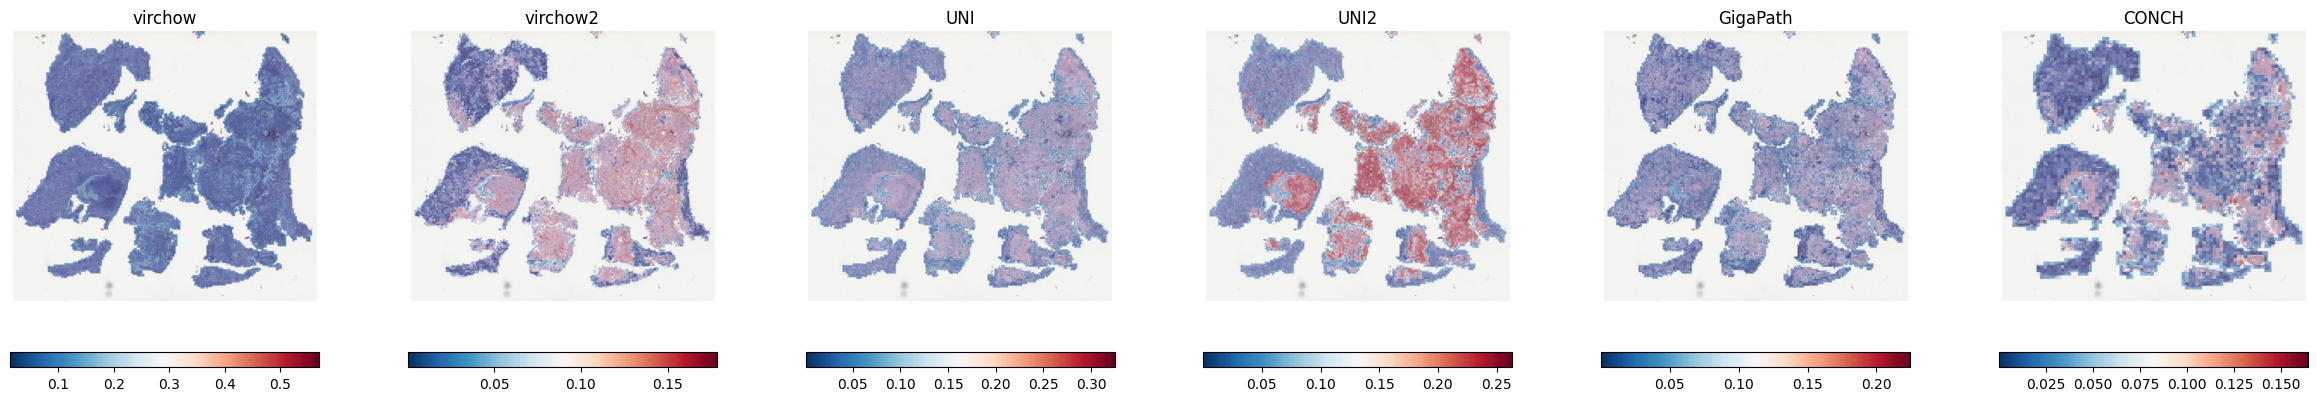

In [6]:
if dataset == 'TCGA':
    svs_root_dir = '/mnt/disk3/svs_data/TCGA/'
    coord_root_dir = '/mnt/disk1/Kidney/Submission_dir/dataset/20x/Prototype/whole_cancer'
else:
    svs_root_dir = '/mnt/disk3/svs_data/'
    coord_root_dir = '/mnt/disk1/Kidney/Submission_dir/dataset/20x/Inference/whole_cancer'
base_dir = '/mnt/disk1/Kidney/Submission_dir/distance_analysis_original_prototype_%s/original/distance/' % dataset
root_dir = '/mnt/disk1/Kidney/Submission_dir/distance_analysis_original_prototype_%s/stainnorm/distance/' % dataset


draw_type = 'heatmap'
target = 'center'
psi_col = 'PSI_'+ str.upper(target[0]) + target[1:]

def collect_all_samples(root_dir, model_list):
    samples = set()
    for model in model_list:
        df = pd.read_csv(f"{root_dir}/{model}_dist_to_%s_prototypes_wide.csv" % target)
        samples.update(df["Sample"].unique().tolist())
    return sorted(list(samples))


all_samples = collect_all_samples(root_dir, model_list)
print(f"#Total unique samples: {len(all_samples)}")

high_patch_dict = {}  # {model: {sample: np.ndarray}}
low_patch_dict = {}  # {model: {sample: np.ndarray}}
psi_patch_dict = {}  # {model: {sample: np.ndarray}}

for model in model_list:
    df = pd.read_csv(os.path.join(root_dir, '%s_%s_psi.csv' % (model, target)))

    df["high"] = df[psi_col] > model_thre[model][0]
    df["low"] = df[psi_col] < model_thre[model][1]

    model_dict_high = {}
    model_dict_low = {}
    model_dict_psi = {}
    for sample, sub in df.groupby("Sample"):
        sub = sub.reset_index(drop=True)
        model_dict_high[sample] = sub.loc[sub["high"]].index.values
        model_dict_low[sample] = sub.loc[sub["low"]].index.values
        model_dict_psi[sample] = sub[psi_col].tolist()

    high_patch_dict[model] = model_dict_high
    low_patch_dict[model] = model_dict_low
    psi_patch_dict[model] = model_dict_psi
    
psi_patch_dict_base = {}  # {model: {sample: np.ndarray}}

for model in model_list:
    df = pd.read_csv(os.path.join(base_dir, '%s_%s_psi.csv' % (model, target)))

    model_dict_psi = {}
    for sample, sub in df.groupby("Sample"):
        sub = sub.reset_index(drop=True)
        model_dict_psi[sample] = sub[psi_col].tolist()
    psi_patch_dict_base[model] = model_dict_psi

model_minmax = {
    model: (
        min(x for lst in model_dict.values() for x in lst),
        max(x for lst in model_dict.values() for x in lst)
    )
    for model, model_dict in psi_patch_dict_base.items()
}

# 기준 모델 하나에서 meta 추출 (어느 모델이든 상관 없음)
ref_df = pd.read_csv(f"{root_dir}/{model_list[0]}_dist_to_{target}_prototypes_wide.csv")
sample_meta = (
    ref_df[["Sample", "Subtype"]]
    .drop_duplicates()
    .set_index("Sample")
)


out_dir = f"{root_dir}/{target}_{draw_type}_overlay_all_samples_per_model"
os.makedirs(out_dir, exist_ok=True)

for i, sample in enumerate(all_samples):
    if sample not in sample_meta.index:
        continue
    if sample != 'TCGA-DW-7834':
        continue
    subtype = sample_meta.loc[sample, "Subtype"]

    print(f"[{i+1}/{len(all_samples)}] Processing {sample}")

    plot_sample_overlay_1x6(
        sample=sample,
        subtype=subtype,
        high_patch_dict=high_patch_dict,
        low_patch_dict=low_patch_dict,
        psi_value = psi_patch_dict,
        model_minmax = model_minmax,
        coord_root_dir=coord_root_dir,
        svs_root_dir=svs_root_dir,
        out_dir=out_dir,
        type=draw_type
    )



In [ ]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import openslide as osd
import os
import glob
from tqdm import tqdm
import json
from PIL import Image, ImageDraw
import openslide


# root_dir = "/mnt/disk1/Kidney/Submission_dir/Annotation/TCGA"
# svs_dir = "/mnt/disk3/svs_data/TCGA"
# save_dir = "/mnt/disk1/Kidney/Submission_dir/distance_analysis_original_prototype_TCGA/original/distance/annotated_wsi"

root_dir = "/mnt/disk1/Kidney/Submission_dir/Annotation/Internal/BORAMAE"
svs_dir = "/mnt/disk3/svs_data/BORAMAE"
save_dir = "/mnt/disk1/Kidney/Submission_dir/distance_analysis_original_prototype_internal/original/distance/annotated_wsi"

os.makedirs(save_dir, exist_ok=True)
tumor_subtype_list = ['TCGA_KIRC', 'TCGA_KICH', 'TCGA_KIRP']

target_sample_list = ['TCGA-CJ-4635', 'TCGA-CJ-4885', 'TCGA-CJ-4890', 'TCGA-CJ-4903', 'TCGA-DW-7839', 'TCGA-BP-5169']
target_sample_list = ['TCGA-DW-7834', 'TCGA-DW-7836', 'TCGA-KO-8408', 'TCGA-KO-8409', 'TCGA-KO-8413', 'TCGA-KM-8477', 'TCGA-KM-8440']
target_sample_list = ['TCGA-BP-5201', 'TCGA-CJ-4904', 'TCGA-P4-AAVM', 'TCGA-KM-8477', 'TCGA-DV-5567', 'TCGA-DV-5566', 'TCGA-CJ-4885']
target_sample_list = ['BS20-4775-9']
target_sample_list = ['KS24-2928-1']
def find_geojson_for_sample(root_dir, sample):
    """
    anno_root_dir/{subtype}/**/*{sample}*.geojson 을 재귀 탐색해 모두 반환.
    """
    pattern = os.path.join(root_dir, f"*{sample}*.geojson")
    return glob.glob(pattern, recursive=True)

def find_svs_for_sample(root_dir, sample):
    """
    anno_root_dir/{subtype}/**/*{sample}*.geojson 을 재귀 탐색해 모두 반환.
    """
    pattern = os.path.join(root_dir, "**", f"*{sample}*.svs")
    file = glob.glob(pattern, recursive=True)
    return file[0]
    for sub in ['KICH', 'KIRP', 'KIRC']:
        sub_dir = os.path.join(root_dir, sub)
        pattern = os.path.join(sub_dir, f"*{sample}*.svs")
   
        file = glob.glob(pattern, recursive=True)
        if len(file) == 0:
            continue
        else:
            return file[0]

def load_geojson_polygons(geojson_path):
    """
    GeoJSON에서 Polygon/MultiPolygon 좌표(픽셀 단위라고 가정)를 ring 단위로 모두 꺼내기.
    반환: [ring1[(x,y),...], ring2[(x,y),...], ...]
    """
    with open(geojson_path, "r") as f:
        gj = json.load(f)

    polys = []

    def add_poly(coords):
        # coords: [ring1, ring2, ...] (outer + holes). 테두리만 원하면 ring 전부 그려도 outline만 그려짐.
        for ring in coords:
            ring_xy = [(float(x), float(y)) for x, y in ring]
            if len(ring_xy) >= 2:
                polys.append(ring_xy)

    gtype = gj.get("type", "")
    if gtype == "FeatureCollection":
        for feat in gj.get("features", []):
            geom = feat.get("geometry", {}) or {}
            t = geom.get("type", "")
            coords = geom.get("coordinates", [])
            if t == "Polygon":
                add_poly(coords)
            elif t == "MultiPolygon":
                for poly_coords in coords:
                    add_poly(poly_coords)
    elif gtype == "Polygon":
        add_poly(gj.get("coordinates", []))
    elif gtype == "MultiPolygon":
        for poly_coords in gj.get("coordinates", []):
            add_poly(poly_coords)

    return polys

def scale_polygons(polys, sx, sy):
    """레벨0 기준 좌표를 썸네일 스케일로 변환."""
    scaled = []
    for ring in polys:
        scaled.append([(int(x * sx), int(y * sy)) for (x, y) in ring])
    return scaled

def draw_polygon_outlines(
    img,
    polys_scaled,
    outline,
    width
) -> Image.Image:
    """썸네일 이미지 위에 다각형 외곽선(테두리)만 그림."""
    if img.mode != "RGBA":
        base = img.convert("RGBA")
    else:
        base = img.copy()
    overlay = Image.new("RGBA", base.size, (0, 0, 0, 0))
    d = ImageDraw.Draw(overlay, "RGBA")
    for ring in polys_scaled:
        if len(ring) < 2:
            continue
        # 폐곡선: 첫 점을 끝에 붙여 선을 닫음
        d.line(ring + [ring[0]], fill=outline, width=width, joint="curve")
    base.alpha_composite(overlay)
    return base.convert("RGB")

def get_thumbnail_and_scale(svs_path, max_width):
    slide = openslide.OpenSlide(svs_path)
    w0, h0 = slide.dimensions
    target_w = min(max_width, w0)
    scale = target_w / w0
    target_h = int(h0 * scale)
    thumb = slide.get_thumbnail((target_w, target_h)).convert("RGB")
    slide.close()
    return thumb, scale, scale  # x,y 동일 스케일

with tqdm(total = len(target_sample_list)) as pbar:
    for sample in target_sample_list:
        svs_path = find_svs_for_sample(svs_dir, sample)
        gj_files = find_geojson_for_sample(root_dir, sample)
        print(svs_path, gj_files)
        # Iterate through the vertices in the XML
        fig, ax = plt.subplots()

        thumb, sx, sy = get_thumbnail_and_scale(svs_path, max_width=2400)

        all_polys = []
        
        for gj in gj_files:
            try:
                all_polys += load_geojson_polygons(gj)
            except Exception as e:
                print(f"[WARN] GeoJSON load failed: {gj} ({e})")
        if all_polys:
            scaled = scale_polygons(all_polys, sx, sy)
            overlay_img = draw_polygon_outlines(
                thumb,
                scaled,
                outline='black',
                width=5
                    )
        ax.imshow(thumb)
        # ax.imshow(overlay_img)
        ax.axis("off")

        save_path = os.path.join(save_dir, f"{sample}_annotated.png")
        fig.savefig(save_path, bbox_inches="tight")
        plt.close(fig)
        pbar.update()
